## Hemoglobin Prediction from Red and Infrared Signals Using PyTorch

This project demonstrates how to use a simple regression neural network in **PyTorch** to predict **hemoglobin concentration (Hb)** based on **Red** and **Infrared (IR)** light intensity values. These are inspired by signal readings commonly used in **non-invasive health monitoring** devices like pulse oximeters.

Data: `Final Dataset Hb PPG.csv` file contains historical results and haemoglobin values. This dataset is publicly available on https://data.mendeley.com/datasets/xdrwrh9zbk/2

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
# Load CSV
df = pd.read_csv('Final Dataset Hb PPG.csv')

# Preview data
print(df.head())

   Red (a.u)  Infra Red (a.u) Gender  Age (year)  Hemoglobin (g/dL)
0   115965.9         105722.9   Male          21               17.5
1   115834.4         105746.7   Male          21               17.5
2   115741.5         105786.0   Male          21               17.5
3   115707.2         105848.1   Male          21               17.5
4   115675.6         105893.5   Male          21               17.5


In [3]:
# Features and target
X = df[['Red (a.u)', 'Infra Red (a.u)']].values
y = df['Hemoglobin (g/dL)'].values.reshape(-1, 1)

In [4]:
# Normalize features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)


In [5]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

In [6]:
# Neural Network Definition
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Model, loss, optimizer
model = RegressionNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
# Training loop
epochs = 8000
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = sum(loss_fn(model(X_val), y_val).item() for X_val, y_val in test_loader) / len(test_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/8000 | Train Loss: 0.9622 | Val Loss: 1.0974
Epoch 2/8000 | Train Loss: 0.9176 | Val Loss: 1.0508
Epoch 3/8000 | Train Loss: 0.8981 | Val Loss: 1.0269
Epoch 4/8000 | Train Loss: 0.8834 | Val Loss: 1.0090
Epoch 5/8000 | Train Loss: 0.8684 | Val Loss: 0.9934
Epoch 6/8000 | Train Loss: 0.8578 | Val Loss: 0.9794
Epoch 7/8000 | Train Loss: 0.8535 | Val Loss: 0.9696
Epoch 8/8000 | Train Loss: 0.8399 | Val Loss: 0.9597
Epoch 9/8000 | Train Loss: 0.8389 | Val Loss: 0.9492
Epoch 10/8000 | Train Loss: 0.8279 | Val Loss: 0.9433
Epoch 11/8000 | Train Loss: 0.8271 | Val Loss: 0.9379
Epoch 12/8000 | Train Loss: 0.8208 | Val Loss: 0.9316
Epoch 13/8000 | Train Loss: 0.8177 | Val Loss: 0.9261
Epoch 14/8000 | Train Loss: 0.8128 | Val Loss: 0.9215
Epoch 15/8000 | Train Loss: 0.8068 | Val Loss: 0.9190
Epoch 16/8000 | Train Loss: 0.8080 | Val Loss: 0.9149
Epoch 17/8000 | Train Loss: 0.8047 | Val Loss: 0.9127
Epoch 18/8000 | Train Loss: 0.8039 | Val Loss: 0.9096
Epoch 19/8000 | Train Loss: 0.8061 | 

In [9]:
# Save the model
torch.save(model.state_dict(), 'hb_model_weights.pth')

# Save scalers
joblib.dump(x_scaler, 'x_scaler.save')
joblib.dump(y_scaler, 'y_scaler.save')

['y_scaler.save']

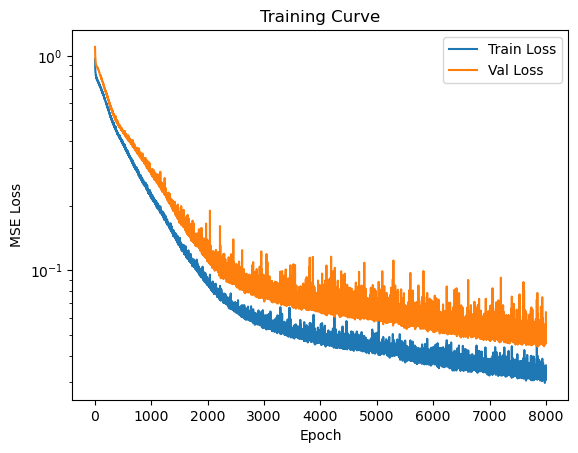

In [10]:
# Plot training curve
plt.semilogy(train_losses, label="Train Loss")
plt.semilogy(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Curve")
plt.show()

In [ ]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    X_val, y_val = next(iter(test_loader))
    preds = model(X_val)
    preds_unscaled = y_scaler.inverse_transform(preds.numpy())
    y_val_unscaled = y_scaler.inverse_transform(y_val.numpy())
    X_val_unscaled = x_scaler.inverse_transform(X_val.numpy())

    df_preds = pd.DataFrame({
    "Red": [X_val_unscaled[i][0] for i in range(10)],
    "IR": [X_val_unscaled[i][1] for i in range(10)],
    "True Hb": [y_val_unscaled[i][0] for i in range(10)],
    "Predicted Hb": [preds_unscaled[i][0] for i in range(10)]})

    # Round values for cleaner display
    df_preds = df_preds.round(2)

    # Print the table
    print("\nSample Predictions:")
    print(df_preds.to_string(index=False))

    print("\nTest Metrics:")
    print(f"RMSE: {mean_squared_error(y_val_unscaled, preds_unscaled, squared=False):.3f}")
    print(f"R2 Score: {r2_score(y_val_unscaled, preds_unscaled):.3f}")



Sample Predictions (First 10 Rows):
          Red            IR   True Hb  Predicted Hb
119277.000000 104092.703125 16.299999         13.69
 86091.000000  77811.898438 14.000000         14.93
112528.101562 114595.203125 11.700000         11.50
115656.898438 103649.898438 12.800000         12.99
121205.203125 100984.296875 11.900000         11.91
102614.703125  67969.703125 10.500000         10.34
 85965.203125  77727.398438 14.000000         14.95
 98697.000000  89405.796875 14.100000         13.91
115436.796875 105861.296875 17.500000         17.48
 95312.398438  87999.398438 11.600000         12.10

Test Metrics:
RMSE: 0.941
R2 Score: 0.750


/opt/anaconda3/envs/torch_FNO/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
import torch
import torch.nn as nn
import joblib
import numpy as np

# Define model architecture
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Load scalers
x_scaler = joblib.load('x_scaler.save')
y_scaler = joblib.load('y_scaler.save')

# Load model
model = RegressionNN()
model.load_state_dict(torch.load('hb_model_weights.pth'))
model.eval()

# Get user input
try:
    red_input = float(input("Enter Red value: "))
    ir_input = float(input("Enter Infra Red value: "))
except ValueError:
    print("Invalid input. Please enter numeric values.")
    exit()

# Preprocess
input_array = np.array([[red_input, ir_input]])
input_scaled = x_scaler.transform(input_array)
input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

# Predict
with torch.no_grad():
    prediction_scaled = model(input_tensor).numpy()
    prediction = y_scaler.inverse_transform(prediction_scaled)

print("\nInput Values You Entered:")
print(f"Red: {red_input}, Infra Red: {ir_input}")

print(f"\nPredicted Hemoglobin Level: {prediction[0][0]:.2f} g/dL")


Input Values You Entered:
Red: 112.0, Infra Red: 112.0

Predicted Hemoglobin Level: -13.73 g/dL
